In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

## Calculate ks value

In [ ]:
def ks(score, test):
    '''
    input:
    score:  numpy array of shape (1,), the prob of being 1.
    test: numpy array of shape (1,), 0 or 1.
    return:
    ks_value: float, ks score estimation
    '''
    get_ks = lambda score, test: ks_2samp(score[test == 1], \
                                                    score[test == 0]).statistic
    ks_value = get_ks(score, test)
    return ks_value

## Calculate F1-score

In [ ]:
def F1(s, c):
    """
    input:
    s, c: two lists
    output:
    F1: F1 value
    """
    s = set(s)
    c = set(c)
    a = len(s & c) / len(s)
    b = len(s & c) / len(c)
    return 2 * a * b / (a + b)

def getS(s):
    S = []
    for i in range(1, len(s)+1):
        temp = s[:i]
        S.append(temp)
    return S

## Data analytics

In [ ]:
score = pd.read_csv("rank3.csv", header=None, names=["id", "score"])
fea=np.load('feature_matrix.npy')

In [ ]:
# set and normalize data
s = score["score"].values
test = fea[:, 3]>0 * 1
a=np.argwhere(fea[:,3]>=3)
test = np.delete(test, a)
s = np.delete(s, a)
Threshold = np.linspace(0.05, 0.95, 1000)
TPR = np.array([])
FPR = np.array([])
min = np.min(s)
max = np.max(s)
score = (s - min) / (max - min)

In [ ]:
# calculate ks value
ks(score, test)

0.09371126143352793

* From the ks value of 9%, we see that the pagerank algorithm is slightly better than randomly classification.

## ks values for different score file

In [ ]:
feature = np.load("feature_matrix.npy")
overdue = [3, 5, 7, 9]
ksvalue = np.array([])
wi = ["weighted", "improved"]
name = []
for i in wi:
    name.append("0%s" %i)
    score = pd.read_csv("./data/score_%s_onlyb.csv" %i, header=None, names=["id", "score"])
    s = score["score"].values
    test = feature[:, 3]>0 * 1
    a = np.argwhere(feature[:, 0]==1)
    test = np.delete(test, a)
    s = np.delete(s, a)
    ksvalue = np.append(ksvalue, ks(s, test))
for i in overdue:
    for k in wi:
        name.append("%d%s" %(i, k))
        score = pd.read_csv("./data/score%d_%s.csv" %(i, k), header=None, names=["id", "score"])
        s = score["score"].values
        test = feature[:, 3]>0 * 1
        a = np.where((feature[:, 3]>=i)|(feature[:, 0]==1))
        test = np.delete(test, a)
        s = np.delete(s, a)
        ksvalue = np.append(ksvalue, ks(s, test))
print(name)
print(ksvalue)

['0weighted', '0improved', '3weighted', '3improved', '5weighted', '5improved', '7weighted', '7improved', '9weighted', '9improved']
[0.01470414 0.01470414 0.05130109 0.02192935 0.01288361 0.01288361
 0.00949837 0.00949837 0.00893672 0.00893672]


### F1 value of score 3

5000
10000
15000
20000
25000
30000
35000


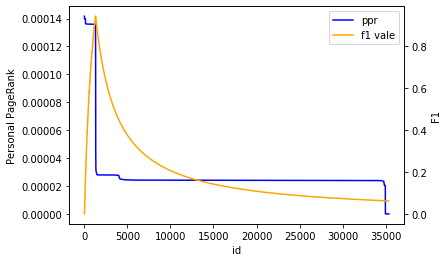

In [ ]:
score = pd.read_csv("rank.csv", header=None, names=["id", "score"])
fea=np.load('feature_matrix.npy')
s = score["score"].values
test = fea[:, 3]>3 * 1
id = np.argsort(-s)
s = -np.sort(-s)
Set = getS(id)
c_list = np.where(test==1)[0].tolist()

# calculate F1 values
def F1_array(Set, c_list):
    f1_arr = []
    for i in range(1, len(Set)+1):
        if i%5000==0:
            print(i)
        s_temp = Set[i-1].tolist()
        f1_arr.append(F1(s_temp, c_list))
    return f1_arr
f1_arr = F1_array(Set, c_list)

fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(len(s)), s, label="ppr", color="b")
ax2.plot(np.arange(len(s)), f1_arr, label="f1 vale", color="orange")
ax1.set_xlabel("id")
ax1.set_ylabel("Personal PageRank")
ax2.set_ylabel("F1")
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

In [ ]:
F1array = np.array(f1_arr)
maxposi = np.argmax(F1array)
print("The best thereshold of pagerank: ", maxposi/len(F1array))

The best thereshold of pagerank:  0.0365815735165239


* With pagerank, we got a decreasing order of the score. From the plot we see that there's a clear scoring gap, which means that the pagerank algorithm gives a significantly higher score to notes belonging to the seed's community.
* The plot also shows that the scoring drop corresponds with the peak of F1 score. The best thereshold of 0.037 can be calculated(we use the thereshold and pagerank score for classification).

## ROC Curve

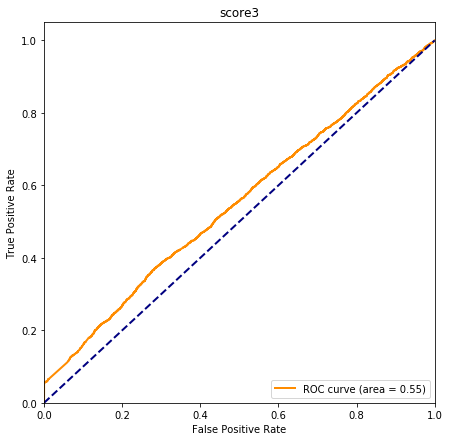

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
score=pd.read_csv('score3.csv',header=None)[1]
fea=np.load('feature_matrix.npy')
if_seed=np.logical_or(fea[:,3]>3,fea[:,0]==1)
score=score[~if_seed]
y=fea[~if_seed,3]>0
fpr, tpr, threshold = roc_curve(y, score)
roc_auc = auc(fpr, tpr)

def plot_roc(fpr, tpr,roc_auc,i):   
    lw=2
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(i)
    plt.legend(loc="lower right")
    plt.show()
    
plot_roc(fpr, tpr,roc_auc,'score3')

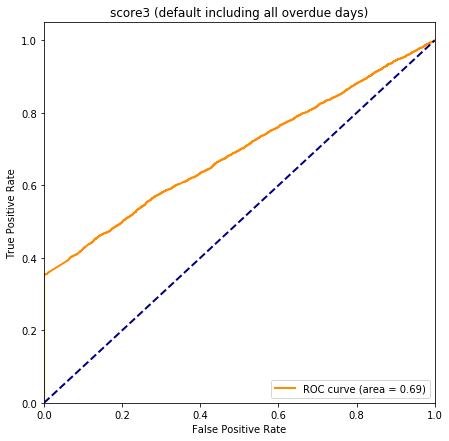

In [ ]:
score=pd.read_csv('score3.csv',header=None)[1]
if_seed=np.logical_or(fea[:,3]>10,fea[:,0]==1)
score=score[~if_seed]
y=fea[~if_seed,3]>0
fpr, tpr, threshold = roc_curve(y, score)
roc_auc = auc(fpr, tpr)

lw=2
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('score3 (default including all overdue days)')
plt.legend(loc="lower right")
plt.show()


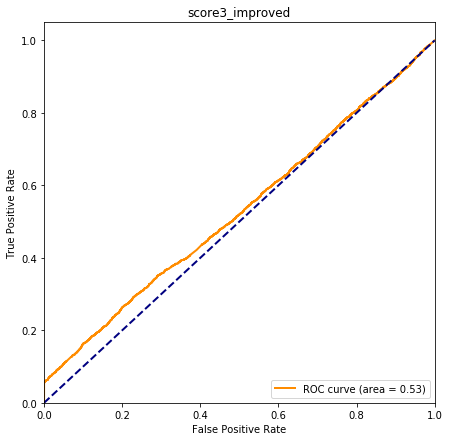

In [ ]:
score=pd.read_csv('score3_improved.csv',header=None)[1]
if_seed=np.logical_or(fea[:,3]>3,fea[:,0]==1)
score=score[~if_seed]
y=fea[~if_seed,3]>0
fpr, tpr, threshold = roc_curve(y, score)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr,roc_auc,'score3_improved')

## Average features grouped by overdue day

In [ ]:
fea=np.load('feature_matrix.npy')
fea.shape
#feature = pd.DataFrame(fea, columns=["node_degree","transitivity","cluster_coef","is_reject", "num_of_appli", "is_new_client", "overdue_day", "num_of_devices", "num_of_phones",
#"last_7d_avg_call_in_duration", "last_7d_avg_call_out_duration", 'last_14d_avg_call_in_duration','last_14d_avg_call_out_duration','last_1m_avg_call_in_duration','last_1m_avg_call_out_duration',
#'last_7d_call_counts','last_14d_call_counts','last_1m_call_counts','is_overdue')
feature = pd.DataFrame(fea, columns=["is_reject", "num_of_appli", "is_new_client", "overdue_day", "num_of_devices", "num_of_phones",
"last_7d_avg_call_in_duration", "last_7d_avg_call_out_duration", "is_overdue"])
df = feature
index=df[df['is_reject']==1].index.to_list()
df.loc[index,'overdue_day']='b'

In [ ]:
for i in ['3','3_improved','5_improved_b','7_improved_b','9_improved_b','_improved_onlyb',
          '5_weighted_b','7_weighted_b','9_weighted_b','_weighted_onlyb']:
    colname="score"+i
    score = pd.read_csv("score{}.csv".format(i), header=None, names=["id", colname])
    df = pd.concat([df, score[colname]*10000], axis=1)

In [ ]:
groupda = df.groupby(["overdue_day"])
groupda.mean().reset_index()

overdue_day  is_reject  num_of_appli  is_new_client  num_of_devices  \
0            0        0.0      2.929629       0.027022        1.555237   
1            1        0.0      2.974564       0.031421        1.517706   
2            2        0.0      2.686327       0.040214        1.479893   
3            3        0.0      2.769784       0.028777        1.647482   
4            4        0.0      2.438776       0.061224        1.663265   
5            5        0.0      2.772727       0.045455        1.704545   
6            6        0.0      3.083333       0.055556        1.611111   
7            7        0.0      2.965517       0.068966        1.517241   
8            8        0.0      2.813008       0.044715        1.634146   
9            9        0.0      2.766892       0.097973        1.527027   
10          10        0.0      2.653005       0.101093        1.565574   
11           b        1.0      3.049802       0.827318        1.535479   

    num_of_phones  last_7d_avg_call_in_duration  \
0        0.397307                     59.928471   
1        0.398005                     58.462130   
2        0.364611                     57.282982   
3        0.453237                     64.028845   
4        0.346939                     64.985644   
5        0.465909                     58.087784   
6        0.277778                     65.136200   
7        0.413793                     67.989177   
8        0.353659                     63.096237   
9        0.476351                     61.111189   
10       0.396175                     61.400127   
11       0.376790                     58.442191   

    last_7d_avg_call_out_duration  is_overdue    score3  score3_improved  \
0                       47.519995         0.0  0.145840         0.138922   
1                       48.564722         0.0  0.146203         0.138700   
2                       47.350958         0.0  0.145740         0.139892   
3                       49.252285         0.0  3.921032         4.053989   
4                       44.209792         0.0  3.920759         4.059813   
5                       56.652360         1.0  3.918867         4.055116   
6                       52.429538         1.0  3.919346         4.049866   
7                       44.998456         1.0  3.921297         4.051062   
8                       45.210804         1.0  3.919508         4.056071   
9                       43.925395         1.0  3.920670         4.058255   
10                      43.205224         1.0  3.920213         4.054537   
11                  -71027.453309         0.0  0.143077         0.139008   

    score5_improved_b  score7_improved_b  score9_improved_b  \
0            0.140202           0.140216           0.140235   
1            0.139767           0.139780           0.139796   
2            0.141053           0.141062           0.141094   
3            0.140054           0.140075           0.140116   
4            0.142354           0.142359           0.142376   
5            0.140322           0.140321           0.140374   
6            0.362936           0.135811           0.135886   
7            0.364405           0.137306           0.137319   
8            0.367505           0.368132           0.140404   
9            0.366164           0.366831           0.138781   
10           0.366966           0.367627           0.373330   
11           0.367335           0.367994           0.373703   

    score_improved_onlyb  score5_weighted_b  score7_weighted_b  \
0               0.140252           0.140202           0.140216   
1               0.139808           0.139767           0.139780   
2               0.141091           0.141053           0.141062   
3               0.140129           0.140054           0.140075   
4               0.142414           0.142354           0.142359   
5               0.140398           0.140322           0.140321   
6               0.135940           0.362936           0.135811   
7               0.137392           0.36

In [ ]:
feature3=df[["overdue_day","is_new_client","num_of_devices","last_7d_avg_call_in_duration"]]
grouped = feature3.groupby(["overdue_day"])
grouped.mean().reset_index()

overdue_day  is_new_client  num_of_devices  last_7d_avg_call_in_duration
0            0       0.027022        1.555237                     59.928471
1            1       0.031421        1.517706                     58.462130
2            2       0.040214        1.479893                     57.282982
3            3       0.028777        1.647482                     64.028845
4            4       0.061224        1.663265                     64.985644
5            5       0.045455        1.704545                     58.087784
6            6       0.055556        1.611111                     65.136200
7            7       0.068966        1.517241                     67.989177
8            8       0.044715        1.634146                     63.096237
9            9       0.097973        1.527027                     61.111189
10          10       0.101093        1.565574                     61.400127
11           b       0.827318        1.535479                     58.442191

## Average graph characteristics vs Score

In [ ]:
score = pd.read_csv("score3.csv", header=None, names=["id","score"])
rank = score["score"].sort_values()
risky_group=rank[-800:].index.to_list()
adj=np.load('adjacent_matrix_improved.npy')
adj=adj[risky_group,:][:,risky_group]
am=adj
am_2 = np.matmul(am,am)
am_3 = np.matmul(am_2,am)
features = pd.DataFrame()
features['node_degree'] = list(am.mean(axis=0))
features['transitivity'] = list(3*np.diag(am_3)/np.trace(am_3))
features['cluster_coef'] = list(np.nan_to_num(np.diag(am_3)/(am_2.sum(axis=0)-np.diag(am_2))))
features['score']=rank[-800:].to_list()
features.set_index(pd.Index(risky_group))
features.sort_values(by=['score'])         

/Users/yc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


node_degree  transitivity  cluster_coef     score
0       0.202500      0.001342      0.312197  0.000392
1       0.440000      0.005399      0.592137  0.000392
2       0.587375      0.009263      0.776781  0.000392
3       0.000375      0.000000      0.000000  0.000392
4       0.286125      0.002509      0.413240  0.000392
..           ...           ...           ...       ...
795     0.615500      0.010070      0.810430  0.000394
796     0.602375      0.009662      0.793322  0.000395
797     0.012375      0.000006      0.021982  0.000397
798     0.436375      0.005592      0.607760  0.000397
799     0.251750      0.001735      0.339172  0.000398

[800 rows x 4 columns]

In [ ]:
features.corr()

node_degree  transitivity  cluster_coef     score
node_degree      1.000000      0.964989      0.953694 -0.020020
transitivity     0.964989      1.000000      0.945925 -0.016827
cluster_coef     0.953694      0.945925      1.000000 -0.030933
score           -0.020020     -0.016827     -0.030933  1.000000

## Subgraph

In [5]:
import networkx as nx
import toyplot

In [3]:
score = pd.read_csv("score3.csv", header=None, names=["id","score"])
rank = score["score"].sort_values()
risky_group=rank[-200:].index.to_list()
adj=np.load('adjacent_matrix_improved.npy')
adj=adj[risky_group,:][:,risky_group]

In [6]:
z = nx.DiGraph(adj)

In [7]:
G=[]
for i in [e for e in z.edges]:
    G.append(list(i))

G=np.array(G)
layout = toyplot.layout.FruchtermanReingold(edges=toyplot.layout.CurvedEdges())
toyplot.graph(G, layout=layout, width=1000);

<svg class="toyplot-canvas-Canvas" height="1000.0px" id="te48eae99beda4385b7f4a01805c648be" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 1000.0 1000.0" width="1000.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> <path d=